In [2]:
from experiments.plots.util import *
from experiments.evaluation_flow.shared import *
import matplotlib

In [3]:
ROOT_LOG_DIR = '/Users/nils/downloads'
NORMAL_DIR = os.path.join(ROOT_LOG_DIR, 'normal')
D_5_DIR = os.path.join(ROOT_LOG_DIR, 'dist-5')
D_10_DIR = os.path.join(ROOT_LOG_DIR, 'dist-10')
D_20_DIR = os.path.join(ROOT_LOG_DIR, 'dist-20')


VERSION = 'version'
FINE_TUNED = 'fine-tuned'
OUTDOOR = 'outdoor'
FOOD = 'food'

TIME_OUTPUT_DIR = '/Users/nils/uni/mmlib-paper/master-thesis/experiments/plots/dist-exp/plots/time-compare'

In [4]:
def get_times(logs_dir, num_nodes):
    # %%
    # get all file sin the directory
    all_files = all_files_in_dir(logs_dir)
    node_server_files = [f for f in all_files if 'server' in f or 'node' in f]
    # for all files extract the metadata (e.g. what model and dataset is used)
    U_IDS = 'u_ids'
    files_and_meta = [(extract_file_meta(f), f) for f in node_server_files]
    # add a mapping: use_case -> model id
    files_and_meta = [({**f[0], **{U_IDS: use_case_ids(f[1])}}, f[1]) for f in files_and_meta]
    # add the parsed events
    files_and_meta = [({**f[0], **{EVENTS: parse_events(f[1])}}, f[1]) for f in files_and_meta]
    # %%
    valid_joined = join_server_and_node_meta(files_and_meta)
    # %%
    times = extract_times(valid_joined, num_nodes=num_nodes, high_level_only=True)

    return times

In [5]:
normal_times = get_times(NORMAL_DIR, 1)
d5_times = get_times(D_5_DIR, 5)
d10_times = get_times(D_10_DIR, 10)
d20_times = get_times(D_20_DIR, 20)


In [6]:
def to_s(values):
    return np.array(list(values)) * 10**-9

def plot_compare_times(baseline, param_update, provenance, save_path=None, ignore_use_cases=[], y_min_max=None):
    print('B: {}'.format(baseline))
    print('P_U: {}'.format(param_update))
    print('M_Prov: {}'.format(provenance))
    if ignore_use_cases:
        for u in ignore_use_cases:
            if u in baseline:
                del baseline[u]
            if u in param_update:
                del param_update[u]
            if u in provenance:
                del provenance[u]

    matplotlib.rcParams.update({'font.size': 24})
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    x_labels = [k.replace('_', '-') for k in baseline.keys()]
    ind = np.arange(len(x_labels))  # the x locations for the groups
    width = 0.3  # the width of the bars
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, to_s(baseline.values()), width, color=A_RED)
    rects2 = ax.bar(ind + width, to_s(param_update.values()), width, color=A_YELLOW)
    rects3 = ax.bar(ind + 2 * width, to_s(provenance.values()), width, color=A_BLUE)
    ax.set_ylabel('Time in seconds')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(x_labels)
    # ax.legend((rects1[0], rects2[0], rects3[0]), ('B', 'U_p', 'M_prov'),
    #           bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
    ax.set_xlabel('Use case')

    plt.xticks(rotation=90)

    if y_min_max:
        axes = plt.gca()
        axes.set_ylim(y_min_max)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
        fig.savefig(save_path + '.pdf', bbox_inches='tight')

    plt.show()

In [7]:
def plot_tts_compare(times, num_nodes):
    metas = filter_meta(times, model=MOBILENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist='outdoor')
    baseline_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_SAVE_TIMES)[HIGH_LEVEL_SAVE_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach=PARAM_UPDATE_IMPROVED, snapshot_type=VERSION, snapshot_dist='outdoor')
    improved_save_param_update_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_SAVE_TIMES)[HIGH_LEVEL_SAVE_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach='provenance', snapshot_type=VERSION, snapshot_dist='outdoor')
    prov_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_SAVE_TIMES)[HIGH_LEVEL_SAVE_TIMES]

    save_path = os.path.join(TIME_OUTPUT_DIR, f'mobilenet-tts-num-nodes-{num_nodes}')

    plot_compare_times(baseline_save_times, improved_save_param_update_times, prov_save_times, ignore_use_cases=[U_2],
                              save_path=save_path, y_min_max=[0,0.5])


B: {'U_1': 98167531.0, 'U_2': 99398117.0, 'N0-U_3_1_1': 103535314.0, 'N0-U_3_1_2': 83577595.0, 'N0-U_3_1_3': 79267563.0, 'N0-U_3_1_4': 86105906.0, 'N0-U_3_2_1': 90382422.0, 'N0-U_3_2_2': 78107971.0, 'N0-U_3_2_3': 78818239.0, 'N0-U_3_2_4': 82552576.0}
P_U: {'U_1': 97641595.0, 'U_2': 107727726.0, 'N0-U_3_1_1': 87308665.0, 'N0-U_3_1_2': 85264383.0, 'N0-U_3_1_3': 79568624.0, 'N0-U_3_1_4': 83485200.0, 'N0-U_3_2_1': 86356143.0, 'N0-U_3_2_2': 84331110.0, 'N0-U_3_2_3': 78390209.0, 'N0-U_3_2_4': 79877907.0}
M_Prov: {'U_1': 93720666.0, 'U_2': 901326745.0, 'N0-U_3_1_1': 377039837.0, 'N0-U_3_1_2': 381829397.0, 'N0-U_3_1_3': 367735979.0, 'N0-U_3_1_4': 368530461.0, 'N0-U_3_2_1': 386919019.0, 'N0-U_3_2_2': 395096616.0, 'N0-U_3_2_3': 392755727.0, 'N0-U_3_2_4': 360738579.0}


<Figure size 576x432 with 0 Axes>

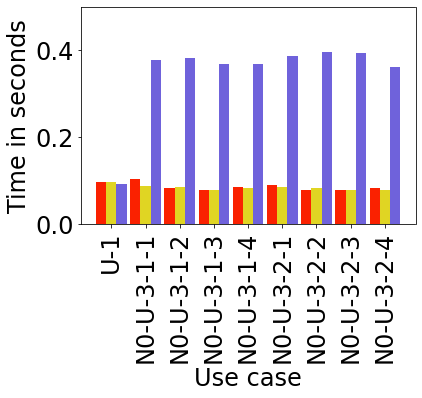

In [8]:
plot_tts_compare(normal_times, 1)

B: {'U_1': 100578095.0, 'U_2': 100002216.0, 'N0-U_3_1_1': 104393955.0, 'N1-U_3_1_1': 88269417.0, 'N2-U_3_1_1': 81269389.0, 'N3-U_3_1_1': 79586152.0, 'N4-U_3_1_1': 85918043.0, 'N0-U_3_1_2': 82143525.0, 'N1-U_3_1_2': 78257429.0, 'N2-U_3_1_2': 83132858.0, 'N3-U_3_1_2': 82235384.0, 'N4-U_3_1_2': 75184868.0, 'N0-U_3_1_3': 83413246.0, 'N1-U_3_1_3': 80987757.0, 'N2-U_3_1_3': 81199075.0, 'N3-U_3_1_3': 79504850.0, 'N4-U_3_1_3': 80818333.0, 'N0-U_3_1_4': 85797979.0, 'N1-U_3_1_4': 76187996.0, 'N2-U_3_1_4': 81148683.0, 'N3-U_3_1_4': 76893068.0, 'N4-U_3_1_4': 82753888.0, 'N0-U_3_1_5': 74880072.0, 'N1-U_3_1_5': 82363013.0, 'N2-U_3_1_5': 84801929.0, 'N3-U_3_1_5': 79717085.0, 'N4-U_3_1_5': 79820747.0, 'N0-U_3_1_6': 84361729.0, 'N1-U_3_1_6': 80926947.0, 'N2-U_3_1_6': 76779207.0, 'N3-U_3_1_6': 83579691.0, 'N4-U_3_1_6': 86010030.0, 'N0-U_3_1_7': 82870120.0, 'N1-U_3_1_7': 80294813.0, 'N2-U_3_1_7': 84996433.0, 'N3-U_3_1_7': 83581246.0, 'N4-U_3_1_7': 80341667.0, 'N0-U_3_1_8': 77340783.0, 'N1-U_3_1_8': 10392

<Figure size 576x432 with 0 Axes>

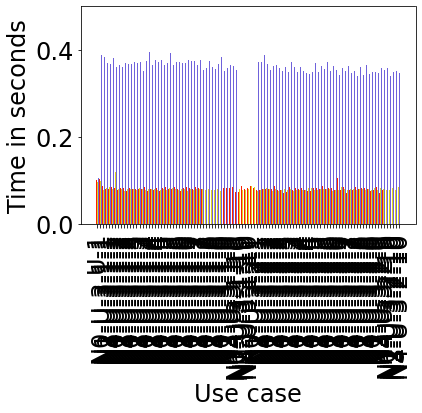

In [9]:
plot_tts_compare(d5_times, 5)

B: {'U_1': 106068984.0, 'U_2': 115272408.0, 'N0-U_3_1_1': 109431945.0, 'N1-U_3_1_1': 86050676.0, 'N2-U_3_1_1': 82076904.0, 'N3-U_3_1_1': 86668625.0, 'N4-U_3_1_1': 81730131.0, 'N5-U_3_1_1': 80042631.0, 'N6-U_3_1_1': 87969398.0, 'N7-U_3_1_1': 84506769.0, 'N8-U_3_1_1': 81502047.0, 'N9-U_3_1_1': 82985806.0, 'N0-U_3_1_2': 81526777.0, 'N1-U_3_1_2': 86407587.0, 'N2-U_3_1_2': 76285501.0, 'N3-U_3_1_2': 89109777.0, 'N4-U_3_1_2': 103748547.0, 'N5-U_3_1_2': 75000846.0, 'N6-U_3_1_2': 76829221.0, 'N7-U_3_1_2': 87921433.0, 'N8-U_3_1_2': 82274407.0, 'N9-U_3_1_2': 81827830.0, 'N0-U_3_1_3': 86395875.0, 'N1-U_3_1_3': 74666449.0, 'N2-U_3_1_3': 72334903.0, 'N3-U_3_1_3': 77370646.0, 'N4-U_3_1_3': 78897502.0, 'N5-U_3_1_3': 86603870.0, 'N6-U_3_1_3': 80490914.0, 'N7-U_3_1_3': 86138293.0, 'N8-U_3_1_3': 83205029.0, 'N9-U_3_1_3': 77542203.0, 'N0-U_3_1_4': 82778462.0, 'N1-U_3_1_4': 90036482.0, 'N2-U_3_1_4': 80578079.0, 'N3-U_3_1_4': 78632211.0, 'N4-U_3_1_4': 83573926.0, 'N5-U_3_1_4': 85162892.0, 'N6-U_3_1_4': 9493

<Figure size 576x432 with 0 Axes>

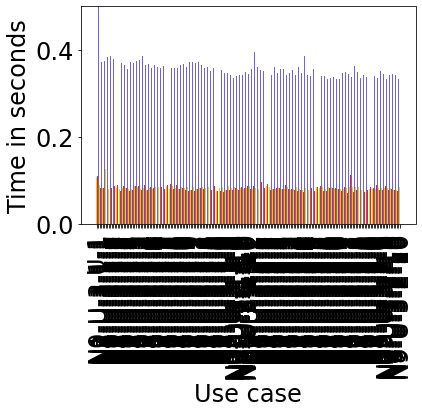

In [10]:
plot_tts_compare(d10_times, 10)

B: {'U_1': 109733238.0, 'U_2': 108776281.0, 'N0-U_3_1_1': 104539638.0, 'N1-U_3_1_1': 84877921.0, 'N2-U_3_1_1': 76065064.0, 'N3-U_3_1_1': 78852797.0, 'N4-U_3_1_1': 92503099.0, 'N5-U_3_1_1': 88116613.0, 'N6-U_3_1_1': 83418370.0, 'N7-U_3_1_1': 84741342.0, 'N8-U_3_1_1': 90732459.0, 'N9-U_3_1_1': 83136242.0, 'N10-U_3_1_1': 86009092.0, 'N11-U_3_1_1': 87775866.0, 'N12-U_3_1_1': 79378097.0, 'N13-U_3_1_1': 80511249.0, 'N14-U_3_1_1': 81945688.0, 'N15-U_3_1_1': 77853874.0, 'N16-U_3_1_1': 75127756.0, 'N17-U_3_1_1': 87811377.0, 'N18-U_3_1_1': 80218077.0, 'N19-U_3_1_1': 82853681.0, 'N0-U_3_1_2': 88219979.0, 'N1-U_3_1_2': 83952383.0, 'N2-U_3_1_2': 79123989.0, 'N3-U_3_1_2': 79779231.0, 'N4-U_3_1_2': 78627658.0, 'N5-U_3_1_2': 81645713.0, 'N6-U_3_1_2': 74473397.0, 'N7-U_3_1_2': 79351893.0, 'N8-U_3_1_2': 86555238.0, 'N9-U_3_1_2': 78426101.0, 'N10-U_3_1_2': 77106912.0, 'N11-U_3_1_2': 86055842.0, 'N12-U_3_1_2': 85100015.0, 'N13-U_3_1_2': 84531032.0, 'N14-U_3_1_2': 85173340.0, 'N15-U_3_1_2': 86682312.0, 'N1

<Figure size 576x432 with 0 Axes>

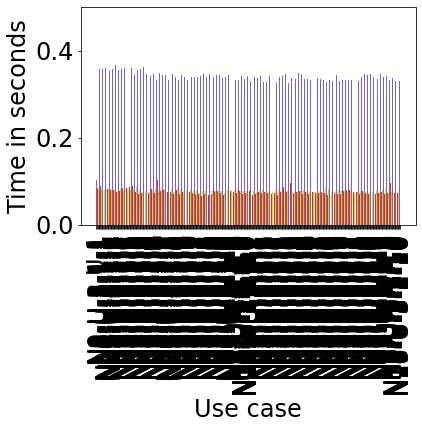

In [11]:
plot_tts_compare(d20_times, 20)

In [12]:
def plot_ttr_compare(times, num_nodes, y_min_max):
    metas = filter_meta(times, model=MOBILENET, approach=BASELINE, snapshot_type=VERSION, snapshot_dist='outdoor')
    baseline_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_RECOVER_TIMES)[HIGH_LEVEL_RECOVER_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach=PARAM_UPDATE_IMPROVED, snapshot_type=VERSION, snapshot_dist='outdoor')
    improved_save_param_update_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_RECOVER_TIMES)[HIGH_LEVEL_RECOVER_TIMES]

    metas = filter_meta(times, model=MOBILENET, approach='provenance', snapshot_type=VERSION, snapshot_dist='outdoor')
    prov_save_times = aggregate_fields(metas, aggregate='median', field_key=HIGH_LEVEL_RECOVER_TIMES)[HIGH_LEVEL_RECOVER_TIMES]

    save_path = os.path.join(TIME_OUTPUT_DIR, f'mobilenet-ttr-num-nodes-{num_nodes}')

    plot_compare_times(baseline_save_times, improved_save_param_update_times, prov_save_times, ignore_use_cases=[U_2],
                              save_path=save_path, y_min_max=y_min_max)

B: {'U_1': 1342530972.0, 'N0_U_3_1_1': 1350662221.0, 'N0_U_3_1_2': 1370305060.0, 'N0_U_3_1_3': 1363772593.0, 'N0_U_3_1_4': 1360704059.0, 'U_2': 1327693022.0, 'N0_U_3_2_1': 1392313186.0, 'N0_U_3_2_2': 1365231012.0, 'N0_U_3_2_3': 1356048423.0, 'N0_U_3_2_4': 1352361230.0}
P_U: {'U_1': 1366508948.0, 'N0_U_3_1_1': 1429845181.0, 'N0_U_3_1_2': 1495619780.0, 'N0_U_3_1_3': 1599423009.0, 'N0_U_3_1_4': 1633616890.0, 'U_2': 1397902481.0, 'N0_U_3_2_1': 1722265653.0, 'N0_U_3_2_2': 1764620545.0, 'N0_U_3_2_3': 1858334969.0, 'N0_U_3_2_4': 1935594623.0}
M_Prov: {'U_1': 159410197.0, 'N0_U_3_1_1': 1588401962.0, 'N0_U_3_1_2': 3365530176.0, 'N0_U_3_1_3': 4305810343.0, 'N0_U_3_1_4': 5450105909.0, 'U_2': 2897221252.0, 'N0_U_3_2_1': 6537908450.0, 'N0_U_3_2_2': 7227037015.0, 'N0_U_3_2_3': 8648806841.0, 'N0_U_3_2_4': 10462255509.0}


<Figure size 576x432 with 0 Axes>

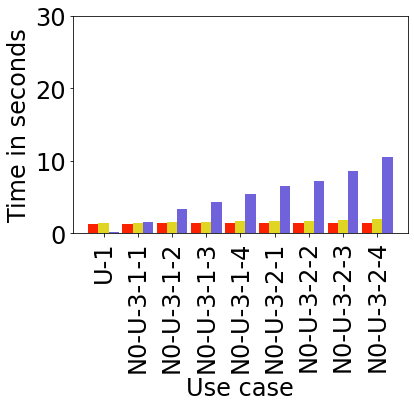

In [13]:
plot_ttr_compare(normal_times, 1, [0,30])

B: {'U_1': 1351866757.0, 'N0_U_3_1_1': 1348382391.0, 'N1_U_3_1_1': 1357897246.0, 'N2_U_3_1_1': 1361253176.0, 'N3_U_3_1_1': 1358972395.0, 'N4_U_3_1_1': 1356263332.0, 'N0_U_3_1_2': 1396909838.0, 'N1_U_3_1_2': 1359744628.0, 'N2_U_3_1_2': 1357713965.0, 'N3_U_3_1_2': 1350743374.0, 'N4_U_3_1_2': 1350364982.0, 'N0_U_3_1_3': 1351121847.0, 'N1_U_3_1_3': 1358336403.0, 'N2_U_3_1_3': 1349945768.0, 'N3_U_3_1_3': 1357060749.0, 'N4_U_3_1_3': 1349937189.0, 'N0_U_3_1_4': 1348798052.0, 'N1_U_3_1_4': 1353108898.0, 'N2_U_3_1_4': 1352369069.0, 'N3_U_3_1_4': 1357189416.0, 'N4_U_3_1_4': 1354234735.0, 'N0_U_3_1_5': 1370632748.0, 'N1_U_3_1_5': 1350197052.0, 'N2_U_3_1_5': 1365251655.0, 'N3_U_3_1_5': 1344706730.0, 'N4_U_3_1_5': 1346754077.0, 'N0_U_3_1_6': 1365010722.0, 'N1_U_3_1_6': 1351566166.0, 'N2_U_3_1_6': 1360153039.0, 'N3_U_3_1_6': 1358372327.0, 'N4_U_3_1_6': 1347769330.0, 'N0_U_3_1_7': 1370167508.0, 'N1_U_3_1_7': 1354820976.0, 'N2_U_3_1_7': 1342927354.0, 'N3_U_3_1_7': 1352523601.0, 'N4_U_3_1_7': 138049647

<Figure size 576x432 with 0 Axes>

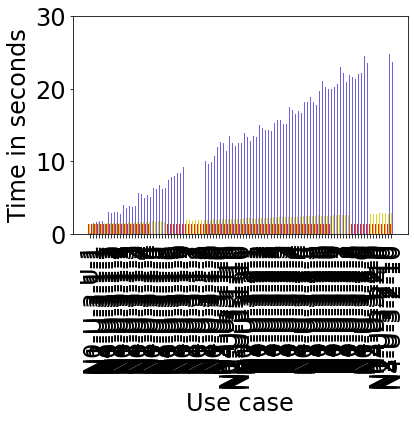

In [14]:
plot_ttr_compare(d5_times, 5, [0,30])

B: {'U_1': 1354237646.0, 'N0_U_3_1_1': 1355974109.0, 'N1_U_3_1_1': 1359782263.0, 'N2_U_3_1_1': 1361060398.0, 'N3_U_3_1_1': 1361389628.0, 'N4_U_3_1_1': 1363648902.0, 'N5_U_3_1_1': 1399057145.0, 'N6_U_3_1_1': 1369948369.0, 'N7_U_3_1_1': 1360116218.0, 'N8_U_3_1_1': 1373691223.0, 'N9_U_3_1_1': 1373697513.0, 'N0_U_3_1_2': 1360844313.0, 'N1_U_3_1_2': 1359404047.0, 'N2_U_3_1_2': 1366678236.0, 'N3_U_3_1_2': 1357087785.0, 'N4_U_3_1_2': 1355124821.0, 'N5_U_3_1_2': 1366061169.0, 'N6_U_3_1_2': 1354241686.0, 'N7_U_3_1_2': 1357036385.0, 'N8_U_3_1_2': 1357049852.0, 'N9_U_3_1_2': 1360519762.0, 'N0_U_3_1_3': 1388021897.0, 'N1_U_3_1_3': 1355438250.0, 'N2_U_3_1_3': 1368519639.0, 'N3_U_3_1_3': 1364686927.0, 'N4_U_3_1_3': 1355907041.0, 'N5_U_3_1_3': 1363995490.0, 'N6_U_3_1_3': 1364663443.0, 'N7_U_3_1_3': 1362976778.0, 'N8_U_3_1_3': 1360609570.0, 'N9_U_3_1_3': 1355684771.0, 'N0_U_3_1_4': 1362621771.0, 'N1_U_3_1_4': 1371102046.0, 'N2_U_3_1_4': 1363044633.0, 'N3_U_3_1_4': 1361237097.0, 'N4_U_3_1_4': 137763056

<Figure size 576x432 with 0 Axes>

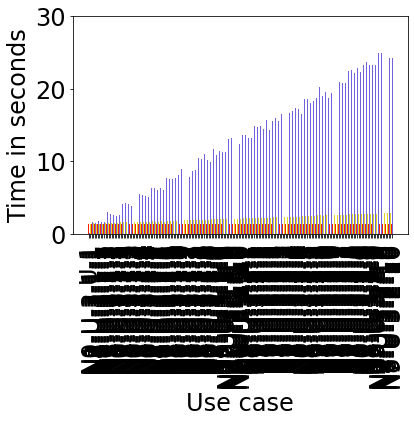

In [15]:
plot_ttr_compare(d10_times, 10, [0,30])

B: {'U_1': 1366106100.0, 'N0_U_3_1_1': 1368915790.0, 'N1_U_3_1_1': 1395573098.0, 'N2_U_3_1_1': 1369530816.0, 'N3_U_3_1_1': 1361487295.0, 'N4_U_3_1_1': 1359915549.0, 'N5_U_3_1_1': 1422210808.0, 'N6_U_3_1_1': 1370323075.0, 'N7_U_3_1_1': 1360394142.0, 'N8_U_3_1_1': 1375837578.0, 'N9_U_3_1_1': 1378538470.0, 'N10_U_3_1_1': 1370373998.0, 'N11_U_3_1_1': 1359303907.0, 'N12_U_3_1_1': 1359181691.0, 'N13_U_3_1_1': 1368132034.0, 'N14_U_3_1_1': 1373511892.0, 'N15_U_3_1_1': 1366717314.0, 'N16_U_3_1_1': 1361186844.0, 'N17_U_3_1_1': 1367279130.0, 'N18_U_3_1_1': 1369829455.0, 'N19_U_3_1_1': 1359972076.0, 'N0_U_3_1_2': 1389282049.0, 'N1_U_3_1_2': 1372552799.0, 'N2_U_3_1_2': 1367052647.0, 'N3_U_3_1_2': 1371193965.0, 'N4_U_3_1_2': 1382064180.0, 'N5_U_3_1_2': 1374478970.0, 'N6_U_3_1_2': 1386843889.0, 'N7_U_3_1_2': 1375629585.0, 'N8_U_3_1_2': 1364336309.0, 'N9_U_3_1_2': 1389431901.0, 'N10_U_3_1_2': 1375372928.0, 'N11_U_3_1_2': 1375503219.0, 'N12_U_3_1_2': 1384721862.0, 'N13_U_3_1_2': 1376709736.0, 'N14_U_3_

<Figure size 576x432 with 0 Axes>

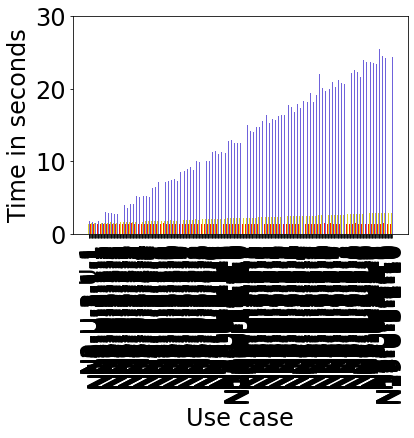

In [16]:
plot_ttr_compare(d20_times, 20, [0,30])